# Portfolio Optimization

### Introduction

The purpose of this project is to demonstrate the use of different portfolio optimization models to select the best combination assets from a wild range of assets while ensuring a minimum expected return. 
Value at Risk and Conditional Value at Risk will be used as mesures of risk. 
We will then compare results from CVaR optimization algorithm and Markowitz optimization model.

In the first part, we will load historical data of different stocks and compute two mesures of returns (percentage return and log return). The data source will be Bourserama. 

In the second part, we will use a minimization problem to get the proportions to invest in each asset of our portfolio in order to minimize our CVAR and VAR.

In the third part, we will use the Markowitz model to find a solution to the same problem.

In the fourth part, we will implement another version of the same problem disscussed in the second part.

### Intuition behind Value At Risk & Conditionnal Value at Risk (aka Conditionnal Expected losses)

Value at Risk (VaR) is the maximum portfolio propotion that can be lost in a given period of time with a specified level of confidence--usually 5%. 

if VaR(95)=3%
Then there is (1-95%) = 5% chance to lose 3% or more on a given day.

If CVAR(95)=4.5%
then in the worst 5% of returns, your average loss will be 4.5%.

In other words, CVAR is a better mesure of risk because it gives us an average expected loss rather than a range of potential losses (as it is given by VAR).

Text(-2.40286,130,'CVaR(95)=-2.40')

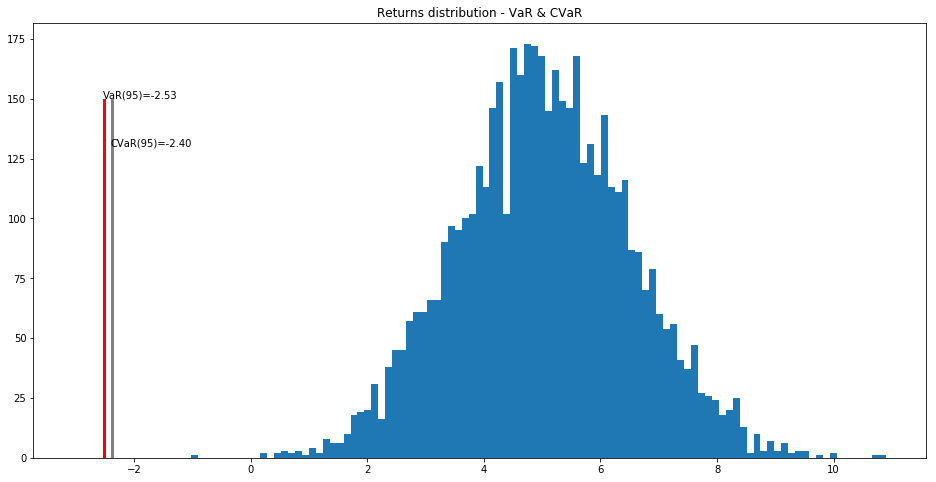

In [101]:
plt.title('Returns distribution - VaR & CVaR')
sigma=1.5
mu=5
plt.hist(np.random.normal(mu,1.5,size=5000),bins=100)
plt.hist(((norm.ppf(1-0.05)*sigma)-mu) * np.ones(150),bins=20,histtype='bar',color='red')
plt.hist(((norm.ppf(1-0.05)*sigma/(1-0.05))-mu) * np.ones(150),bins=20,histtype='bar',color='grey')
plt.annotate('VaR(95)=%0.2f'%(((norm.ppf(1-0.05)*sigma)-mu)),(((norm.ppf(1-0.05)*sigma)-mu),150))
plt.annotate('CVaR(95)=%0.2f'%((norm.ppf(1-0.05)*sigma/(1-0.05))-mu),(((norm.ppf(1-0.05)*sigma/(1-0.05))-mu),130))

## Part I : Loading hitorical stocks data 

I used the Boursorama website to download text files of stock data for different companies.

Below I concatenate all the different column, in order to create a historical return matrix.

Note : We can choose, as a mesure of return, the percentage return or the log return.

In [ ]:
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
rcParams['figure.figsize'] = 16, 8

In [47]:
#Retrieving all the data from the .txt files
vinci_stocks = pd.read_csv('VINCI_2019-01-08.txt', sep="\t")
vinci_stocks = vinci_stocks.drop(columns=['ouv','haut','vol','devise','Unnamed: 7'])
sg_stocks = pd.read_csv('SOCIETEGENERALE_2019-01-08.txt', sep="\t")
sg_stocks = sg_stocks.drop(columns=['ouv','haut','vol','devise','Unnamed: 7'])
sanofi_stocks = pd.read_csv('SANOFI_2019-01-08.txt', sep="\t")
sanofi_stocks = sanofi_stocks.drop(columns=['ouv','haut','vol','devise','Unnamed: 7'])
bouyg_stocks = pd.read_csv('BOUYGUES_2019-01-08.txt', sep="\t")
bouyg_stocks = bouyg_stocks.drop(columns=['ouv','haut','vol','devise','Unnamed: 7'])
bnp_stocks = pd.read_csv('BNPPARIBASBRA_2019-01-08.txt', sep="\t")
bnp_stocks = bnp_stocks.drop(columns=['ouv','haut','vol','devise','Unnamed: 7'])
quantum_stocks = pd.read_csv('QUANTUMGENOMICS_2019-01-09.txt', sep="\t")
quantum_stocks = quantum_stocks.drop(columns=['ouv','haut','vol','devise','Unnamed: 7'])

0.06513975388660306
-0.026489748992332085
99% VaR is 3.9


In [51]:
#renaming the closing price of each asset dataframe
vinci_stocks.rename({'clot':'VINCI'},axis=1,inplace=True)
bnp_stocks.rename({'clot':'BNP'},axis=1,inplace=True)
sg_stocks.rename({'clot':'SG'},axis=1,inplace=True)
sanofi_stocks.rename({'clot':'SANOFI'},axis=1,inplace=True)
bouyg_stocks.rename({'clot':'BOUYG'},axis=1,inplace=True)
quantum_stocks.rename({'clot':'QUANTUM'},axis=1,inplace=True)
#merging all dataframes (we only keep the closing price of each one)
historical_data=pd.concat([vinci_stocks[['date','VINCI']],bnp_stocks['BNP'],
                           bouyg_stocks['BOUYG'],sg_stocks['SG'],sanofi_stocks['SANOFI'],quantum_stocks['QUANTUM']], axis=1)


99% CVaR/ES is 7.6
99% CVaR/ES is 5.93


In [ ]:
#We compute the percentage return and the logarithmic return for each stock
for column in ['VINCI','SANOFI','BNP','SG','BOUYG','QUANTUM']:
    column_name='pct_change'+column
    historical_data[column_name]=historical_data[column].pct_change()
    column_name='log_ret'+column
    historical_data[column_name]=np.log(historical_data[column]) - np.log(historical_data[column].shift(1)) 

historical_data.dropna(inplace=True)    

In [ ]:
#We plot the percentage and log return distribution for each stock 
rcParams['figure.figsize'] = 14, 4
for column in ['VINCI','SANOFI','BNP','SG','BOUYG','QUANTUM']:
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    axs[0].hist(historical_data['pct_change'+column].dropna(),bins=100,color='blue')
    axs[0].set(xlabel='Returns', ylabel='Frequency',
       title="Pct change for Stock price distribution for %s  , mean=%0.3f"%(column,np.mean(historical_data['pct_change'+column])))
    
    x_1=historical_data['log_ret'+column].dropna()
    y_1=np.random.normal(np.mean(historical_data['log_ret'+column]),
                                         np.std(historical_data['log_ret'+column]),
                                         size=historical_data.shape[0])
    axs[1].hist([x_1,y_1],bins=100,label=['hist','normal'],alpha=0.9)
    axs[1].legend()
    axs[1].set(xlabel='Returns', ylabel='Frequency',
       title="Log change for Stock price distribution for %s , mean=%0.3f"%(column,np.mean(historical_data['log_ret'+column])))


# Part 2 : CVaR & VaR optimization problem

Note : My first idea behind this, was to use the return matrix as a starting point for the optimization problem, but since the assets I choosed have very low volatility and return, this won't help in showing the interest behind the use of the portfolio optimization technics. I managed to solve this issu by generate some gaussian return matrix with adjusted mean return and variance to make it easy to demonstrate the interest of these methods.

In [61]:
#number of assets
n = 4
#number of scenarios
J=10000
#to compute VaR(99%) and CVaR(99%)
beta=0.01
#Mean and variance for the return distribution
means=np.array([0.05,0.1,0.02,0.16])
sigmas=np.array([0.07,0.13,0.05,0.15])

returns=np.array([ np.random.normal(means[i],sigmas[i],size=(n_sim_histo)) for i in range (n)])

In [62]:
#Initializing the weights of each asset in the portfolio
weights_init = 2 * np.ones((n,1)) / n
#Computing the initial Value at Risk of our portfolio
var_init=np.quantile(np.dot(returns.T,weights_init),(1-beta),axis=0)
#Creating the initial input vector that is going to be used to solve our problem
input_init=np.concatenate((weights_init,np.array([var_init])),axis=0)

In [63]:
#lists to record the evolution of the optimization step
VaR_list=[]
CVaR_list=[]
Sum_returns_list=[]
Sum_weights_list=[]

def objective_function(input_vect):
    input_vect=input_vect.reshape(n+1)
    weights=input_vect[0:n]
    var=input_vect[n]
    VaR_list.append(var)
    CVaR_list.append(np.asscalar(var + 1/((1-beta)*J) * np.sum(np.maximum.reduce([np.dot(returns.T,weights) - var,np.zeros((n_sim_histo))]))))
    return np.asscalar(var + 1/((1-beta)*J) * np.sum(np.maximum.reduce([np.dot(returns.T,weights) - var,np.zeros((n_sim_histo))])))

def inequality_constraint(input_vect):
    weights=input_vect[0:n]
    Sum_returns_list.append(np.dot(np.mean(returns,axis=1).T,weights))
    return + np.dot(np.mean(returns,axis=1).T,weights) - Expected_return 

def equality_constraint(input_vect):
    weights=input_vect[0:n]
    Sum_weights_list.append(np.sum(weights))
    return 1 - np.sum(weights)

variables_bounds = np.concatenate(([(0,1) for i in range(n)],[(0,None)]),axis=0)

In [70]:
ineq_const={'type':'ineq','fun': inequality_constraint}
eq_const={'type':'eq','fun': equality_constraint}

optimal_portfolios=[]
Expected_return=0.02

res = minimize(objective_function,input_init.reshape(n+1),constraints=[ineq_const,eq_const],bounds=variables_bounds, tol=1e-6,options={'disp': False})
optimal_portfolios.append((res.fun,res.x[0:n]))


In [72]:
print(objective_function(input_init))
print(inequality_constraint(input_init))
print(equality_constraint(input_init))

0.41370215179181774
[0.14391061]
-1.0


In [73]:
print(objective_function(res.x))
print(inequality_constraint(res.x))
print(equality_constraint(res.x))

0.03161141977938335
6.383466671922022e-12
-2.220446049250313e-16


### 1]- Comparison of both initial and final values of VaR and CVaR of the portfolio

Text(0.0316114,280,'CVaR=0.03')

C:\Users\bbbbb\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


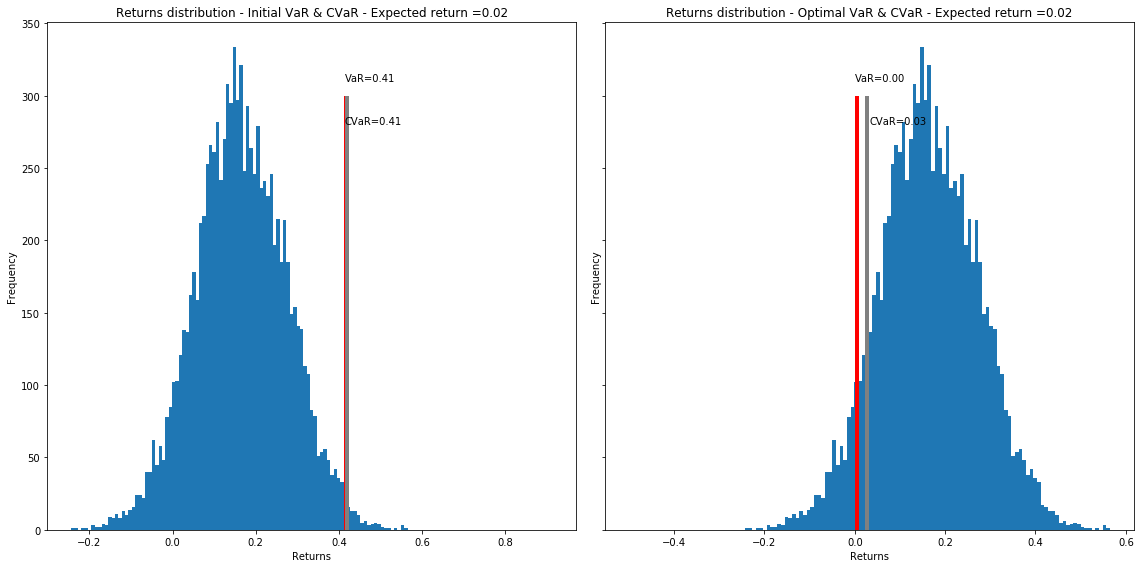

In [75]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].set(xlabel='Returns', ylabel='Frequency',
       title='Returns distribution - Initial VaR & CVaR - Expected return =%0.2f'%(Expected_return))
axs[0].hist(np.dot(returns.T,weights_init),bins=100)
axs[0].hist(var_init * np.ones(300),bins=100,histtype='bar',color='red')
axs[0].hist(objective_function(input_init) * np.ones(300),bins=100,histtype='bar',color='grey')
axs[0].annotate('VaR=%0.2f'%(var_init),(var_init,310))
axs[0].annotate('CVaR=%0.2f'%(objective_function(input_init)),(objective_function(input_init),280))

axs[1].set(xlabel='Returns', ylabel='Frequency',
       title='Returns distribution - Optimal VaR & CVaR - Expected return =%0.2f'%(Expected_return))
axs[1].hist(np.dot(returns.T,weights_init),bins=100)
axs[1].hist(res.x[n]*np.ones(300),bins=100,histtype='bar',color='red')
axs[1].hist(res.fun*np.ones(300),bins=100,histtype='bar',color='grey')
axs[1].annotate('VaR=%0.2f'%(res.x[n]),(res.x[n],310))
axs[1].annotate('CVaR=%0.2f'%(res.fun),(res.fun,280))

### 2]- Parameters evolution through the optimization process

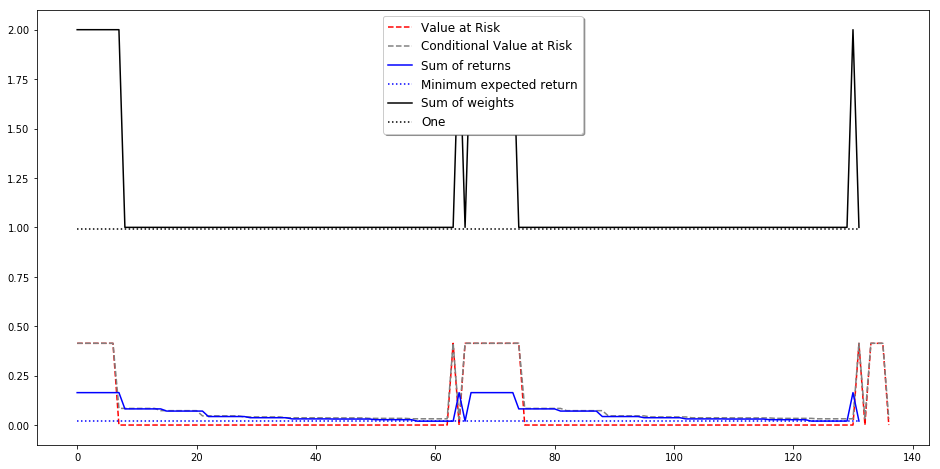

In [76]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
#adding the optimal values to the iteration's lists
VaR_list.append(res.x[n])
CVaR_list.append(res.fun)

ax.plot(range(len(VaR_list)), VaR_list, 'k--', label='Value at Risk',color='red')
ax.plot(range(len(CVaR_list)), CVaR_list, 'k--', label='Conditional Value at Risk',color='grey')

ax.plot(range(len(Sum_returns_list)), Sum_returns_list, label='Sum of returns',color='blue')
ax.plot(range(len(Sum_returns_list)), Expected_return * np.ones(len(Sum_returns_list)),  'k:',label='Minimum expected return',color='blue')

ax.plot(range(len(Sum_weights_list)), Sum_weights_list, label='Sum of weights',color='black')
ax.plot(range(len(Sum_returns_list)), 0.99*np.ones(len(Sum_returns_list)), 'k:', label='One',color='black')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')

plt.show()

### 3]- Drawing the decision frontier curve for multiple portfolios

Given a historical return matrix.

By multiple portfolio, we mean different case scenarios of choosing the weights of each asset in the portfolio.

In [71]:
nb_assets=4
#number of scenarios of weights combination 
scenarios=10000
#matrix of weights of each scenario
#we pick 3 weights randomly from 0 to 1
weights_portfolios=[[np.random.rand()*1/(nb_assets-1) for i in range(nb_assets-1)] for i in range(scenarios)] 
#the fourth value = 1 - (weigth1 + weight2 + weight3)
weights_portfolios=np.concatenate(((1-np.sum(weights_portfolios,axis=1)).reshape(scenarios,1),np.array(weights_portfolios)),axis=1)
#the return of each portfolio of the #scenarios we initialized
returns_portfolios=[np.dot(np.mean(returns,axis=1).T,weights_portfolios[i]) for i in range(scenarios)]

In [73]:
#computing the var of each portfolio of the # of scenarios
vars_portfolios=[np.quantile(np.dot(returns.T,weights_portfolios[i]),(1-beta),axis=0) for i in range(scenarios)]
#computing the cvar of each portfolio of the # of scenarios
cvars_portfolios=[(np.asscalar(vars_portfolios[i] + 1/((1-beta)*J) 
                               * np.sum(np.maximum.reduce([np.dot(returns.T,weights_portfolios[i]) - vars_portfolios[i],
                                                           np.zeros((n_sim_histo))])))) for i in range(scenarios)]

In [76]:
optimal_portfolios=[]
Expected_return=0.01

for i in range(10):
    res = minimize(objective_function,input_init.reshape(n+1),constraints=[ineq_const,eq_const],bounds=variables_bounds, tol=1e-6,options={'disp': False})
    optimal_portfolios.append((res.fun,res.x[0:n]))
    Expected_return+=0.01

[Text(0,0.5,'Expected Return'),
 Text(0.5,0,'CVaR'),
 Text(0.5,1,'Decision frontier')]

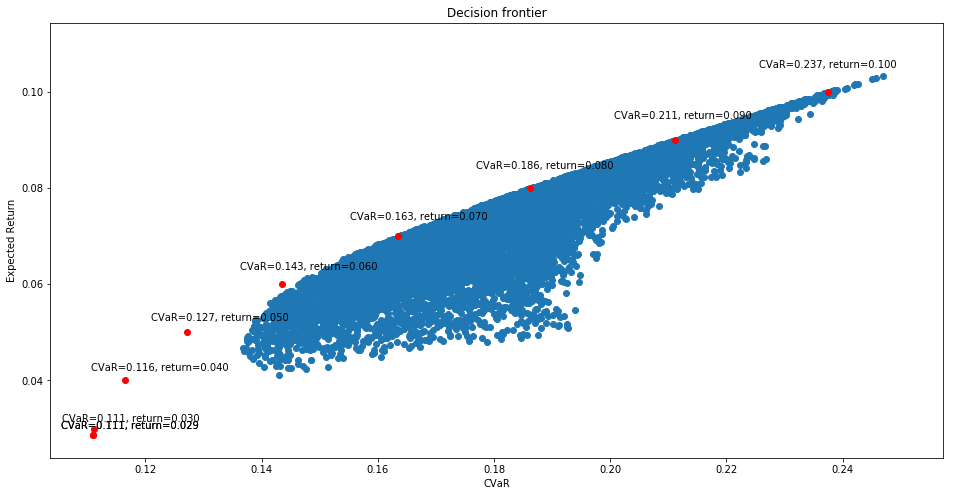

In [77]:
fig, ax = plt.subplots()

ax.scatter(cvars_portfolios,returns_portfolios)

pfolio_return=[np.dot(np.mean(returns,axis=1).T,np.array(optimal_portfolios[i][1][0:n])) for i in range(len(optimal_portfolios))]
pfolio_cvar=[optimal_portfolios[i][0] for i in range(len(optimal_portfolios))]

ax.scatter(pfolio_cvar,pfolio_return,color='red')


for i in range(len(optimal_portfolios)):
    ax.annotate('CVaR=%0.3f, return=%0.3f'%(pfolio_cvar[i],pfolio_return[i]),(pfolio_cvar[i]*0.95,pfolio_return[i]*1.05))

ax.set(xlabel='CVaR', ylabel='Expected Return',
       title='Decision frontier')

# Part 3 : Portfolio optimization - Markowitz Model

In this part, we will optimize the Markowitz Model to maximize the return of our portfolio.

We will be using the CVaR as a risk mesure.

In [167]:
n = 4
J=10000
means=np.array([0.05,0.1,0.02,0.16])
sigmas=np.array([0.1,0.13,0.05,0.15])
returns=np.array([ np.random.normal(means[i],sigmas[i],size=(n_sim_histo)) for i in range (n)])



In [169]:
J=returns.shape[1]
beta=0.05
allowed_CVaR=0.1

weights_init = 2 * np.ones((n,1)) / n
var_init=np.quantile(np.dot(returns.T,weights_init),(1-beta),axis=0)
input_init=np.concatenate((weights_init,np.array([var_init])),axis=0)

In [170]:
#Maximize (+ Rendement) <=> Minimize (- Rendement)
def objective_function(input_vect):
    input_vect=input_vect.reshape(n+1)
    weights=input_vect[0:n]
    return - np.dot(np.mean(returns,axis=1).T,weights)


def inequality_constraint(input_vect):
    input_vect=input_vect.reshape(n+1)
    weights=input_vect[0:n]
    var=input_vect[n]
    return allowed_CVaR - np.asscalar(var + 1/((1-beta)*J) * np.sum(np.maximum.reduce([np.dot(returns.T,weights) - var,np.zeros((J))])))


def equality_constraint(input_vect):
    weights=input_vect[0:n]
    return 1 - np.sum(weights)

variables_bounds = np.concatenate(([(0,1) for i in range(n)],[(0,None)]),axis=0)

In [171]:
ineq_const={'type':'ineq','fun': inequality_constraint}
eq_const={'type':'eq','fun': equality_constraint}

optimal_portfolios=[]
Expected_return=0.01

for i in range(20):
    res = minimize(objective_function,input_init.reshape(n+1),constraints=[ineq_const,eq_const],bounds=variables_bounds, tol=1e-6,options={'disp': False})
    
    CVaR = np.asscalar(res.x[n] + 1/((1-beta)*J) * np.sum(np.maximum.reduce([np.dot(returns.T,res.x[0:n]) - res.x[n],np.zeros((J))])))
    # On récupère - Valeur optimale
    optimal_portfolios.append((- res.fun,CVaR))
    
    allowed_CVaR+=0.02
    

In [172]:
optimal_portfolios

[(0.026243396632965963, 0.11601068192926149),
 (0.036465964955256475, 0.1200008328238096),
 (0.05424858462051388, 0.14000006864680087),
 (0.06503094098477002, 0.16000007357862808),
 (0.07420087231033413, 0.1800002527905133),
 (0.08252909116381693, 0.2000001672122797),
 (0.09036266473957517, 0.22000059715790288),
 (0.09789002933562788, 0.24000055435090104),
 (0.10520742075224315, 0.2600001022649866),
 (0.1123710509628032, 0.28000016266914945),
 (0.11915755910836906, 0.29999999999988036),
 (0.1253892563004474, 0.32000079722746616),
 (0.1312221405254145, 0.34000000000035635),
 (0.1368269372177222, 0.36000005352297304),
 (0.1419438614849895, 0.38000000000002965),
 (0.14636650932966613, 0.3999999999999973),
 (0.15031622246585857, 0.42000031177569286),
 (0.15400666277328628, 0.44000034527836773),
 (0.15748367717847697, 0.4600000000000256),
 (0.15934318740042266, 0.4800005089213635)]

[Text(0,0.5,'Expected Return'),
 Text(0.5,0,'CVaR'),
 Text(0.5,1,'Decision Frontier Curve')]

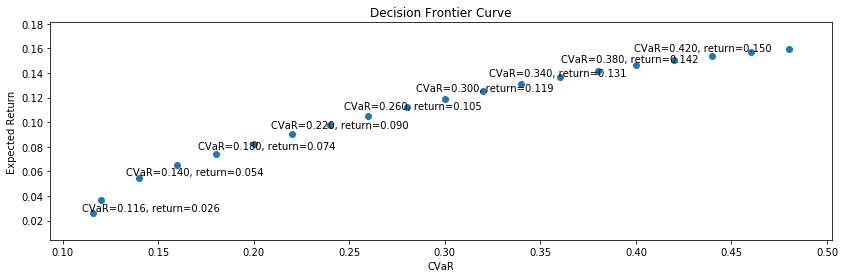

In [173]:
fig, ax = plt.subplots()

pfolio_return = np.array([(optimal_portfolios[i][0]) for i in range(len(optimal_portfolios))])
pfolio_cvar = np.array([optimal_portfolios[i][1] for i in range(len(optimal_portfolios))])
ax.scatter(pfolio_cvar,pfolio_return)

for i in range(len(optimal_portfolios)-2):
    if(i%2==0):
        ax.annotate('CVaR=%0.3f, return=%0.3f'%(pfolio_cvar[i],pfolio_return[i]),(pfolio_cvar[i]*0.95,pfolio_return[i]*1.05))


ax.set(xlabel='CVaR', ylabel='Expected Return',
       title='Decision Frontier Curve')


### CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE

In [351]:
polynome=np.polyfit([optimal_portfolios[i][1] for i in range(len(optimal_portfolios))], 
                    [(optimal_portfolios[i][0]) for i in range(len(optimal_portfolios))], 2)

array([-8.39316067e-02, -6.06294314e-02, -3.87692830e-02, -1.83511615e-02,
        6.24933027e-04,  1.81590006e-02,  3.42510413e-02,  4.89010551e-02,
        6.21090419e-02,  7.38750019e-02,  8.41989348e-02,  9.30808409e-02,
        1.00520720e-01,  1.06518572e-01,  1.11074398e-01,  1.14188196e-01,
        1.15859967e-01,  1.16089712e-01,  1.14877429e-01,  1.12223120e-01,
        1.08126784e-01,  1.02588421e-01,  9.56080305e-02,  8.71856135e-02,
        7.73211695e-02,  6.60146986e-02,  5.32662008e-02,  3.90756760e-02,
        2.34431243e-02,  6.36854574e-03, -1.21480598e-02, -3.21066922e-02,
       -5.35073516e-02, -7.63500379e-02, -1.00634751e-01, -1.26361491e-01,
       -1.53530258e-01, -1.82141052e-01, -2.12193873e-01, -2.43688721e-01,
       -2.76625596e-01, -3.11004498e-01, -3.46825426e-01, -3.84088382e-01,
       -4.22793364e-01, -4.62940374e-01, -5.04529410e-01, -5.47560473e-01,
       -5.92033564e-01, -6.37948681e-01, -6.85305825e-01, -7.34104996e-01,
       -7.84346194e-01, -

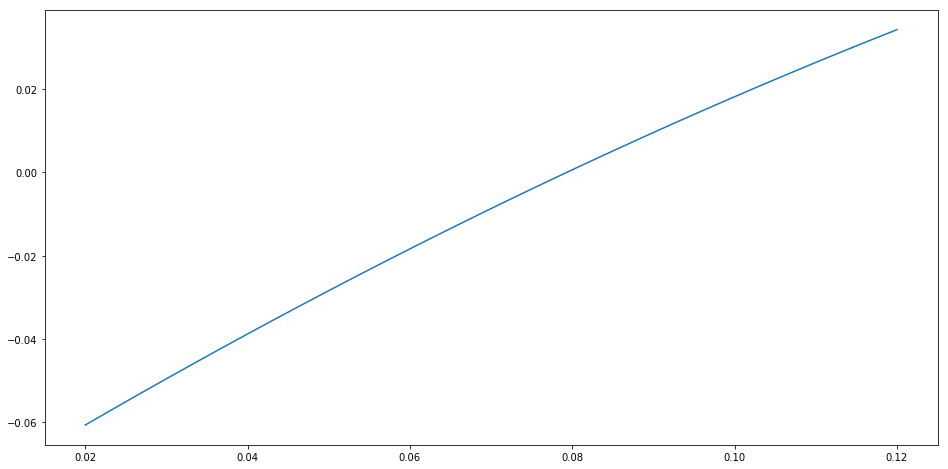

In [355]:
p= np.poly1d(polynome)
plt.plot(np.linspace(0.02, 0.12, 100),p(np.linspace(0.02, 0.12, 100)))


# Part 4 : Other formulation of the CVaR minimization problem

In [52]:
n = 4
n_sim_histo = 100
J=n_sim_histo
beta=0.95

means=np.array([0.05,0.1,0.02,0.16])
sigmas=np.array([0.07,0.13,0.05,0.15])

returns=np.array([ np.random.normal(means[i],sigmas[i],size=(n_sim_histo)) for i in range (n)])

In [50]:
n = 1
n_sim_histo = historical_data.shape[0]
J=n_sim_histo
beta=0.05
returns=np.array([ np.random.normal(-0.0001314601,0.04237393,size=(n_sim_histo))])

In [53]:
weights_init = 2 * np.ones((n,1)) / n
var_init=np.quantile(np.dot(returns.T,weights_init),(1-beta),axis=0)


z_init=np.zeros((J,1))
input_init=np.concatenate([weights_init,np.array([var_init]),z_init],axis=0).reshape(n+1+J)


def objective_function(input_vect):
    input_vect=input_vect.reshape(n+1+J)
    #weights=input_vect[0:n]
    var=input_vect[n]
    z=input_vect[n+1:]
    return np.asscalar(var + 1/((1-beta)*J) * np.sum(z))

def inequality_constraint(input_vect):
    weights=input_vect[0:n]
    var=input_vect[n]
    z=input_vect[n+1:]
    constraint_1 = z 
    constraint_2 = z - (np.dot(returns.T,weights) - var )
    constraint_3 = + np.dot(np.mean(returns,axis=1).T,weights) - Expected_return 

    return np.concatenate([constraint_1,constraint_2,[constraint_3]],axis=0)

def equality_constraint(input_vect):
    weights=input_vect[0:n]
    return 1 - np.sum(weights)

In [54]:
variables_bounds = np.concatenate(([(0,1) for i in range(n)],[(0,None)],[(0,None) for i in range(J)]))
ineq_const={'type':'ineq','fun': inequality_constraint}
eq_const={'type':'eq','fun': equality_constraint}

optimal_portfolios=[]
Expected_return=0.01

res = minimize(objective_function,input_init.reshape(n+1+J),constraints=[ineq_const,eq_const],bounds=variables_bounds, tol=1e-6,options={'disp': False})
optimal_portfolios.append((res.fun,res.x[0:n]))

Text(0.105954,280,'CVaR=0.11')

C:\Users\bbbbb\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


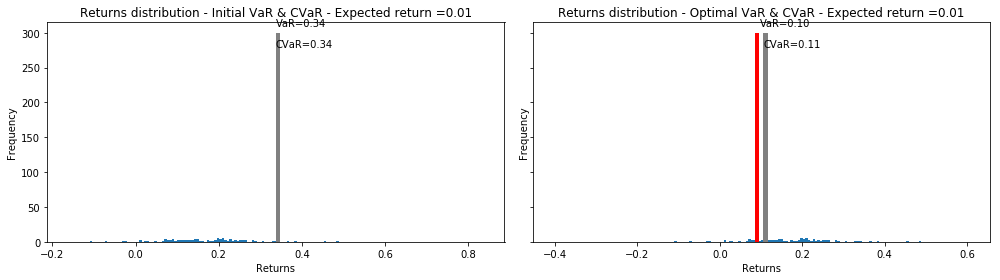

In [55]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].set(xlabel='Returns', ylabel='Frequency',
       title='Returns distribution - Initial VaR & CVaR - Expected return =%0.2f'%(Expected_return))
axs[0].hist(np.dot(returns.T,weights_init),bins=100)
axs[0].hist(var_init * np.ones(300),bins=100,histtype='bar',color='red')
axs[0].hist(objective_function(input_init) * np.ones(300),bins=100,histtype='bar',color='grey')
axs[0].annotate('VaR=%0.2f'%(var_init),(var_init,310))
axs[0].annotate('CVaR=%0.2f'%(objective_function(input_init)),(objective_function(input_init),280))

axs[1].set(xlabel='Returns', ylabel='Frequency',
       title='Returns distribution - Optimal VaR & CVaR - Expected return =%0.2f'%(Expected_return))
axs[1].hist(np.dot(returns.T,weights_init),bins=100)
axs[1].hist(res.x[n]*np.ones(300),bins=100,histtype='bar',color='red')
axs[1].hist(res.fun*np.ones(300),bins=100,histtype='bar',color='grey')
axs[1].annotate('VaR=%0.2f'%(res.x[n]),(res.x[n],310))
axs[1].annotate('CVaR=%0.2f'%(res.fun),(res.fun,280))

In [32]:
print((res.fun,res.x[0:n]))

(0.11476697824435052, array([2.04599758e-01, 2.93205405e-02, 7.66079702e-01, 9.36945833e-15]))


# References

- https://coral.ie.lehigh.edu/~ted/files/ie447/lectures/Lecture24.pdf Financial, Optimization ISE 347/447, by Dr. Ted Ralphs. 
- https://tesi.luiss.it/12528/1/forghieri-simone-tesi-2014.pdf, Portfolio Optimization using CVaR, by Simone Forghieri.